In [159]:
import sys
sys.path.append('C:\\Users\\IFIc\\Projects\\sabatsw\\laserlab\\scripts')
import matplotlib.pyplot as plt
from skimage import io

from galvo_python.galvos import *
from galvo_python.gaussian2dFit import *

In [495]:
serialport = open_serial_port(port_name="COM4")

SerialException: could not open port 'COM4': PermissionError(13, 'Access is denied.', None, 5)

## Initialize and configure cam0

In [356]:
import pylablib.aux_libs.devices.DCAM as cam
from pylablib.aux_libs.devices.DCAM_lib import lib, DCAMLibError

from time import sleep

In [12]:
#cam.restart_lib()   #  Run if driver is not recognized

In [483]:
cam.get_cameras_number()

cam.DCAMCamera(0).get_model_data()

ModelData(vendor='Hamamatsu', model='C13440-20C', serial_number='S/N: 303065', camera_version='4.31.B')

In [496]:
cam0 = cam.DCAMCamera(0)
lib.dcamapi_uninit()     # For some reason this must be run before opening the camera
cam0.open()

min_texp = cam0.properties['EXPOSURE TIME'].min
cam0.set_value('EXPOSURE TIME', min_texp)

cam0.start_acquisition()
cam0.get_status()

'busy'

In [485]:
cam0.properties['EXPOSURE TIME']

cam0.properties['EXPOSURE TIME'].get_value()


cam0.properties

Property(name='b'EXPOSURE TIME'', id=2031888, min=0.0010036691729323308, max=10.0, unit=1)

In [112]:
cam0.stop_acquisition()

## Align laser after galvo 

In [4]:
center0 = [int(65534./2)-3780,int(65534./2)+8900]#calibrated on 19/02/2020
move_to_positionXY(serialport, [0,0], center=center0)

NameError: name 'move_to_positionXY' is not defined

In [387]:
center0 = [int(65534./2) + 3200, int(65534./2) +  7900] #calibrated on 13/05/2020
move_to_positionXY(serialport, [0,0], center=center0)

In [500]:
center0 = [int(65534./2) + 3150, int(65534./2) +  4650] #calibrated on 26/05/2020, normal incidence on galvo

move_to_positionXY(serialport, [0,0], center=center0)

# Take snap of laser after galvo and before lenses 

##  At d = 3 cm from galvo

### Move laser to center of DCAM 

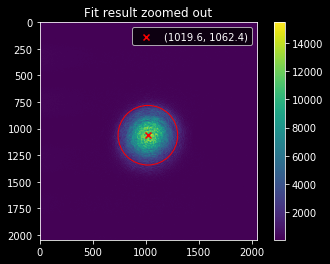

In [376]:
%matplotlib inline
plt.style.use('dark_background')

move_to_positionXY(serialport, [0,4000], center=center0)
sleep(1)
frame0 = cam0.get_frame(100)

gray = plt.imshow(frame0)
plt.colorbar(gray)
bestfit2 = guessNfitGaussian2d(frame0)

In [373]:
from skimage import io
io.imsave("nolens_noiris_3cm.tiff", frame0)

In [377]:
bestfit2[3]

280.7183325525021

# At d = 160 cm from galvo 

### Move laser to center of DCAM 

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/nolens_withIris_160cm.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


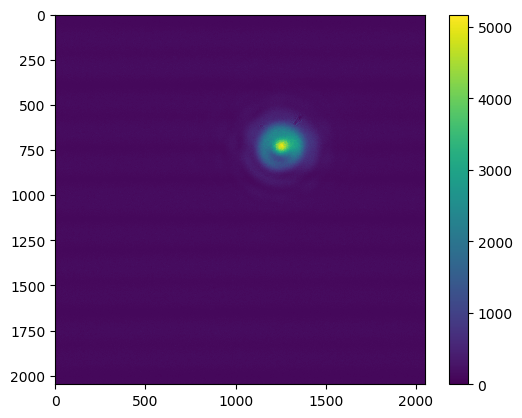

In [92]:
frame0 = cam0.get_frame(100)

gray = plt.imshow(frame0)
io.imsave('./aligning_4f_052020/nolens_withIris_160cm.tiff', frame0)
plt.colorbar(gray)

[2781.4084079099557,
 1301.1804046576372,
 682.4838725278931,
 255.2518064627757,
 0.049462923331967196]

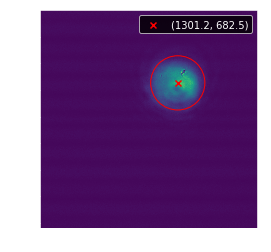

In [378]:
frame0 = plt.imread('./aligning_4f_052020/nolens_noIris_160cm.tiff')

%matplotlib inline
bestfit1 = guessNfitGaussian2d(frame0, flag_p=False)

plot_fit_result(frame0, bestfit1)
bestfit1

In [194]:
xref, yref = bestfit1[1:3]
rRef = bestfit1[3]
rRef

255.2518064627757

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/nolens_noIris_160cm.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


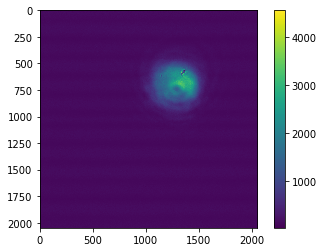

In [96]:
frame0 = cam0.get_frame(100)

gray = plt.imshow(frame0)
io.imsave('./aligning_4f_052020/nolens_noIris_160cm.tiff', frame0)
plt.colorbar(gray)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/nolens_withIris_160cm.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


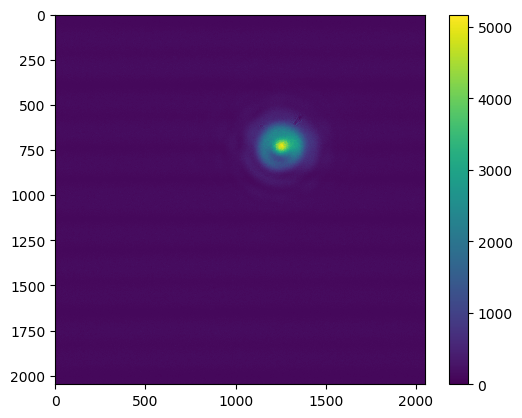

In [92]:
frame0 = cam0.get_frame(100)

gray = plt.imshow(frame0)
io.imsave('./aligning_4f_052020/nolens_withIris_160cm.tiff', frame0)
plt.colorbar(gray)

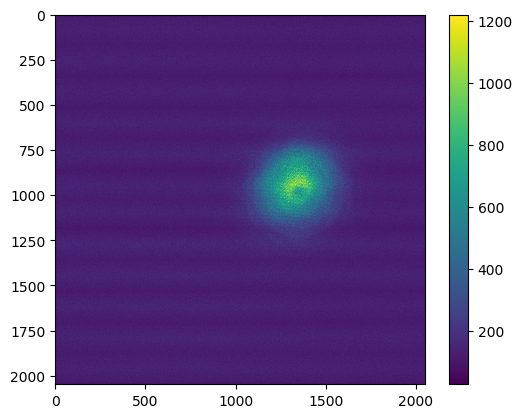

In [119]:
%matplotlib inline
plt.style.use('default')
frame0 = cam0.get_frame(100)

gray = plt.imshow(frame0)
plt.colorbar(gray)

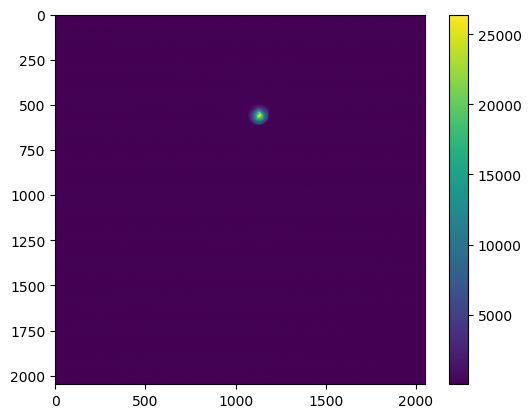

In [176]:
%matplotlib inline
plt.style.use('default')
frame0 = cam0.get_frame(100)

gray = plt.imshow(frame0)
plt.colorbar(gray)

In [177]:
guess_centroid(frame0)

(566, 1127)

In [136]:
def guessNfitGaussian2d(im : np.ndarray, sizeRoi:int = 500, DEBUG : bool = False, flag_p : bool = True) :
    """Fit 2d gaussian to an RGB image, perform ROI selection, parameter setting
    DEBUG flag shows whole process, flag_p shows final result"""
#     img = rgb2gray(im)
    mx = guess_centroid(im)
    bounds = bound_roi(im, mx, sizeRoi)
    imroi = select_roi(im, bounds)

    mxroi = guess_centroid(imroi)
    flp = False
    if DEBUG:
        flp = True
        pl = plt.imshow(imroi)#, cmap=plt.get_cmap('gray'))
        plt.scatter(mx[1] - bounds[2], mx[0] - bounds[0], marker='x', color='r')

    # Guess sigmas

    fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=flp)
    sigma_x = fitc[2]
    sigma_y = fitr[2]

    p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]
    if DEBUG:
        plot_fit_result(imroi, p0)
        plt.title('Initial parameter guess')

    # Fit to 2dGaussian

    fit = fitGauss2d(imroi, p0 = p0)

    pars = make_params(fit)
    if DEBUG:
        plot_fit_result(imroi, pars)
        plt.title('Fit result')

    #  Zoom out of ROI

    newp = zoom_out(pars, bounds)
    if flag_p:
        plot_fit_result(im, newp)
        plt.title('Fit result zoomed out')
    return newp


In [151]:
#plt.imshow(frame0)
mx = guess_centroid(frame0)
bounds = bound_roi(frame0, mx, 500)

imroi = select_roi(frame0, bounds)
mxroi = guess_centroid(imroi)


fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=False)

sigma_x = fitc[2]
sigma_y = fitr[2]

p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]
fit = fitGauss2d(imroi, p0)
pars = make_params(fit)
zoom_out(pars, bounds)

[841.3136397956196,
 1510.2508654965036,
 533.7788864146585,
 231.54949453652,
 0.14549727102110285]

In [153]:
bounds, mx

([0, 999, 975, 1975], (499, 1475))

In [158]:
pars, fitr, fitc

([841.3136397956196,
  535.2508654965035,
  533.7788864146585,
  231.54949453652,
  0.14549727102110285],
 array([802.62712168, 532.43546483, 113.00845255, 124.8940662 ]),
 array([812.976399  , 537.81085441, 118.7907813 , 109.09364001]))

In [156]:
pars[1:3]

[535.2508654965035, 533.7788864146585]

In [155]:
newc = [p + s for p, s in zip(pars[1:3], bounds[2::-2])]
newc

[1510.2508654965036, 533.7788864146585]

[841.3136397956196,
 1510.2508654965036,
 533.7788864146585,
 231.54949453652,
 0.14549727102110285]

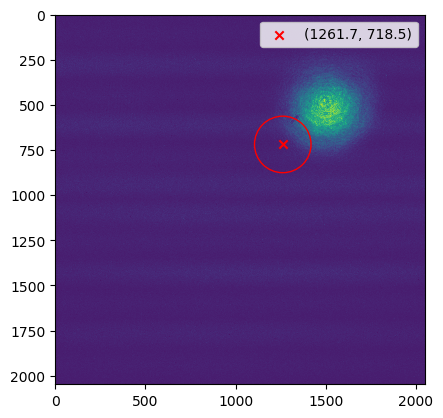

In [137]:
bestfit2 = guessNfitGaussian2d(frame0, flag_p=False)

plot_fit_result(frame0, bestfit1)
bestfit2

In [125]:
bestfit2[3]

264.13484902685525

###### So with the two lenses we'll need to recover a spot size of 255 +- 3 px

##### Okay, not too bad collimation: 62 px in x and 400 px in y

# Set lens 2 at d = 80 cm from galvo 

## Live find same position (beam goes through lens center)
Move lens position, not galvo to get centroid = (1000, 1000)

In [173]:
guess_centroid(frame0)

(557, 1137)

<IPython.core.display.Javascript object>


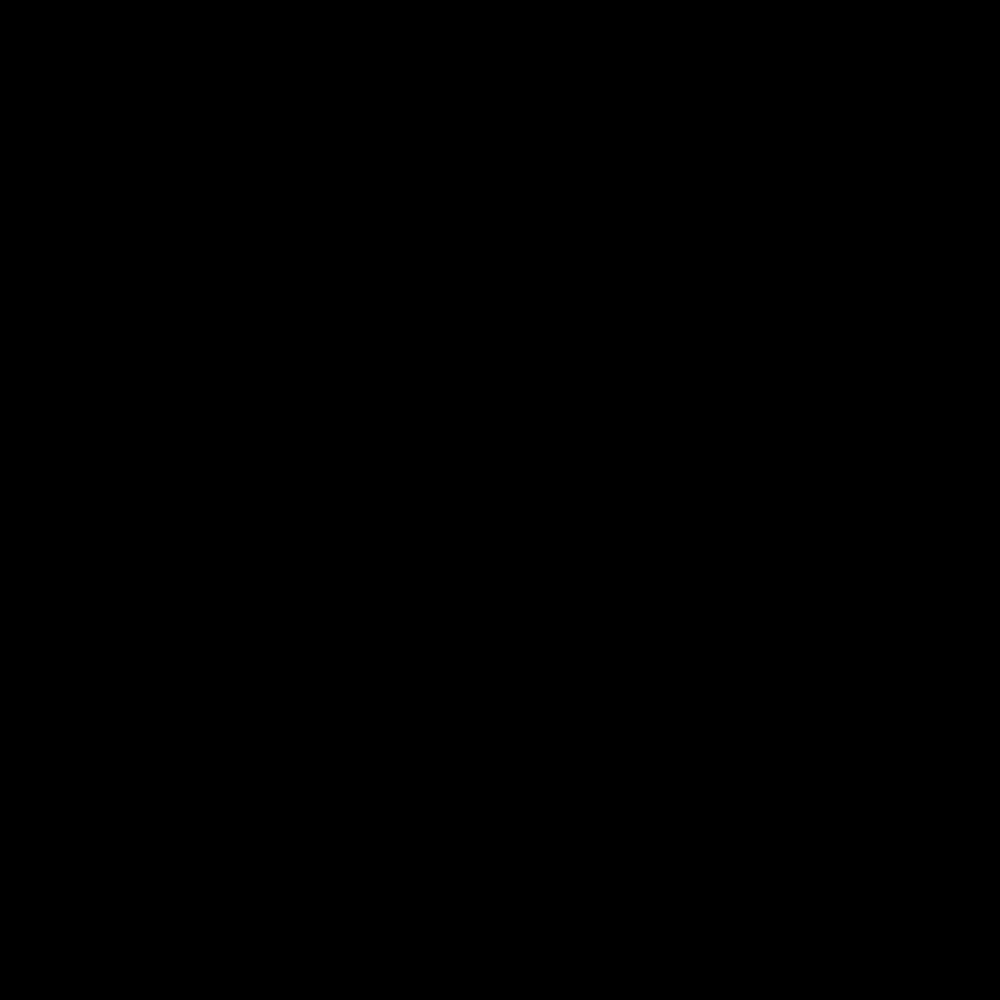

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


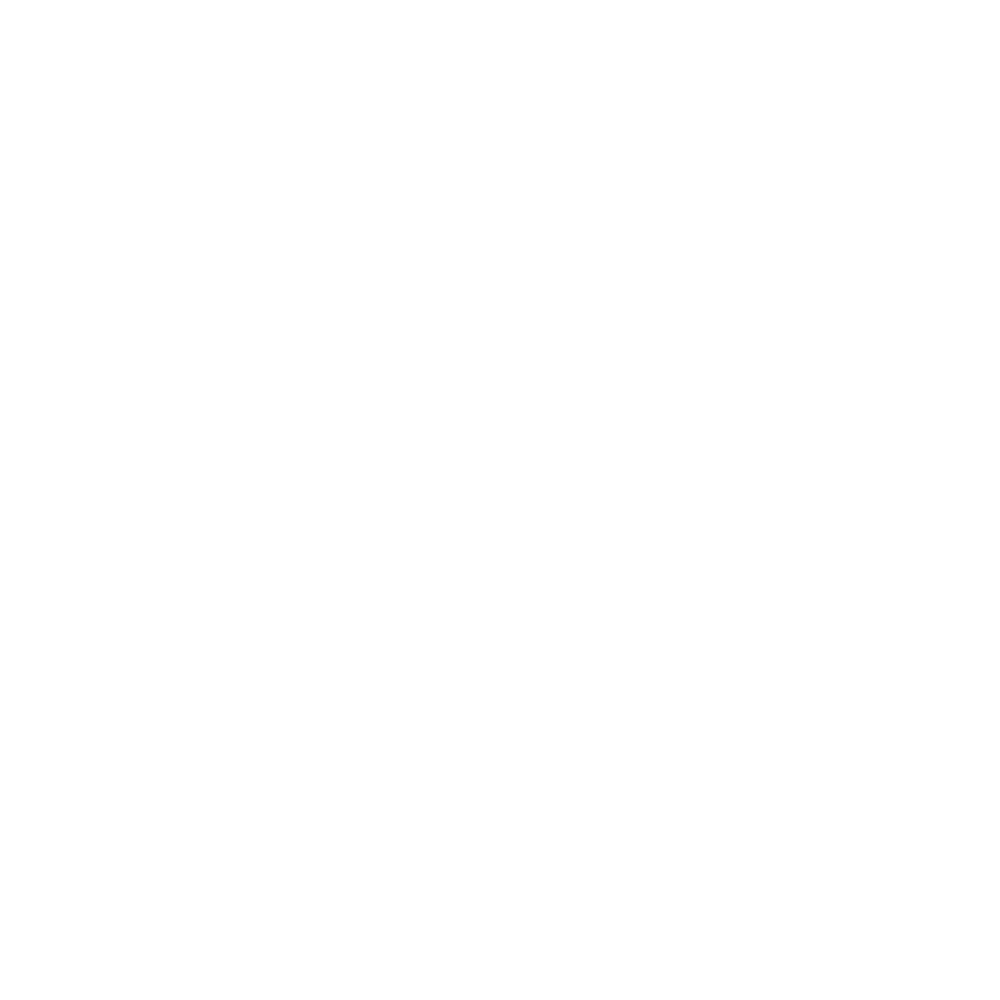

In [179]:
%matplotlib notebook
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,10))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')
sx, sy = [], []
while True:
    fig = plt.gcf()
    ax1 = fig.add_subplot(1, 1, 1)
    
    frame0 = cam0.get_frame(100)

    img = ax1.imshow(frame0)
    fig.colorbar(img)
    mx = guess_centroid(frame0)

    ax1.scatter(x=xref, y=yref, marker='x',
     color='g', label = 'Ref: (%.1f, %.1f)' %(xref, yref))
    
    ax1.scatter(x=mx[1], y=mx[0], marker='x',
     color='r', label = '(%.1f, %.1f)' %(mx[0], mx[1]))
    ax1.legend()

    fig.canvas.draw()
    fig.tight_layout()
    #fig.canvas.update()
    fig.canvas.flush_events()
    plt.clf()

C:\Users\IFIc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/lens2_center.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


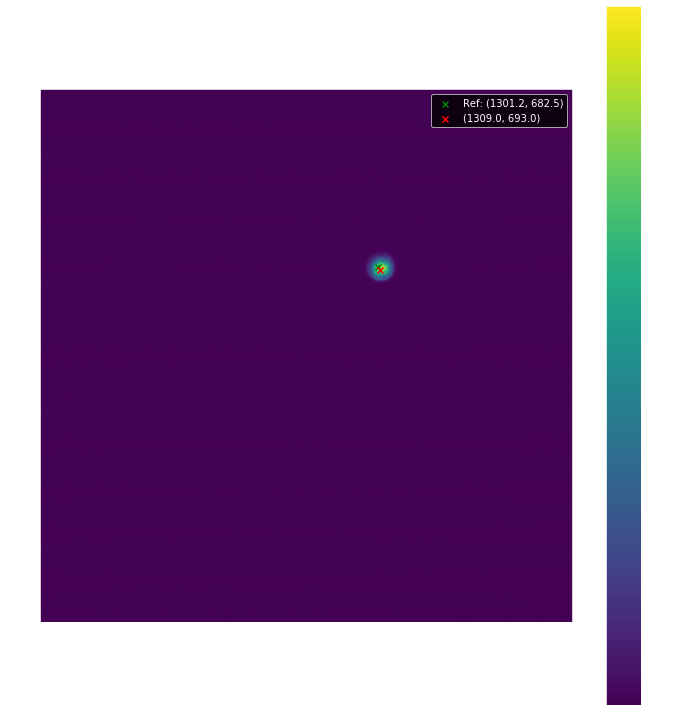

In [186]:
%matplotlib inline
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,10))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')
sx, sy = [], []

fig = plt.gcf()
ax1 = fig.add_subplot(1, 1, 1)

frame0 = cam0.get_frame(100)

img = ax1.imshow(frame0)
fig.colorbar(img)
mx = guess_centroid(frame0)

ax1.scatter(x=xref, y=yref, marker='x',
 color='g', label = 'Ref: (%.1f, %.1f)' %(xref, yref))

ax1.scatter(x=mx[1], y=mx[0], marker='x',
 color='r', label = '(%.1f, %.1f)' %(mx[1], mx[0]))
ax1.legend()

fig.canvas.draw()
fig.tight_layout()
#fig.canvas.update()
fig.canvas.flush_events()
io.imsave('./aligning_4f_052020/lens2_center.tiff', frame0)
plt.savefig('./aligning_4f_052020/lens2_center.png')

<IPython.core.display.Javascript object>


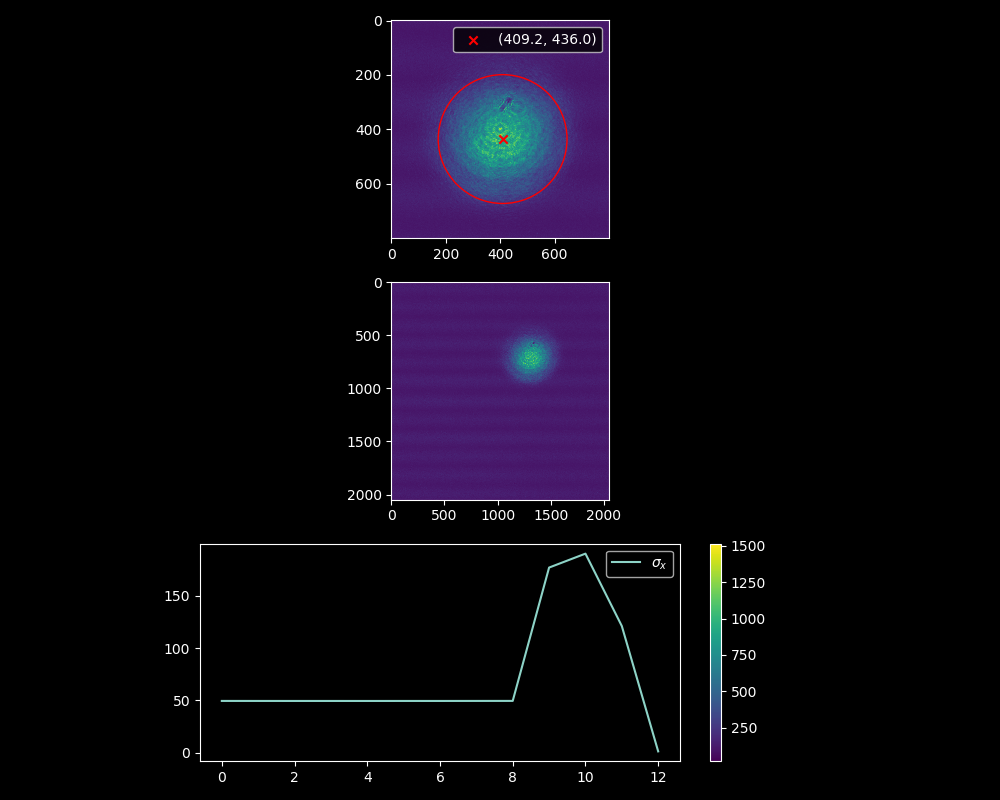

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


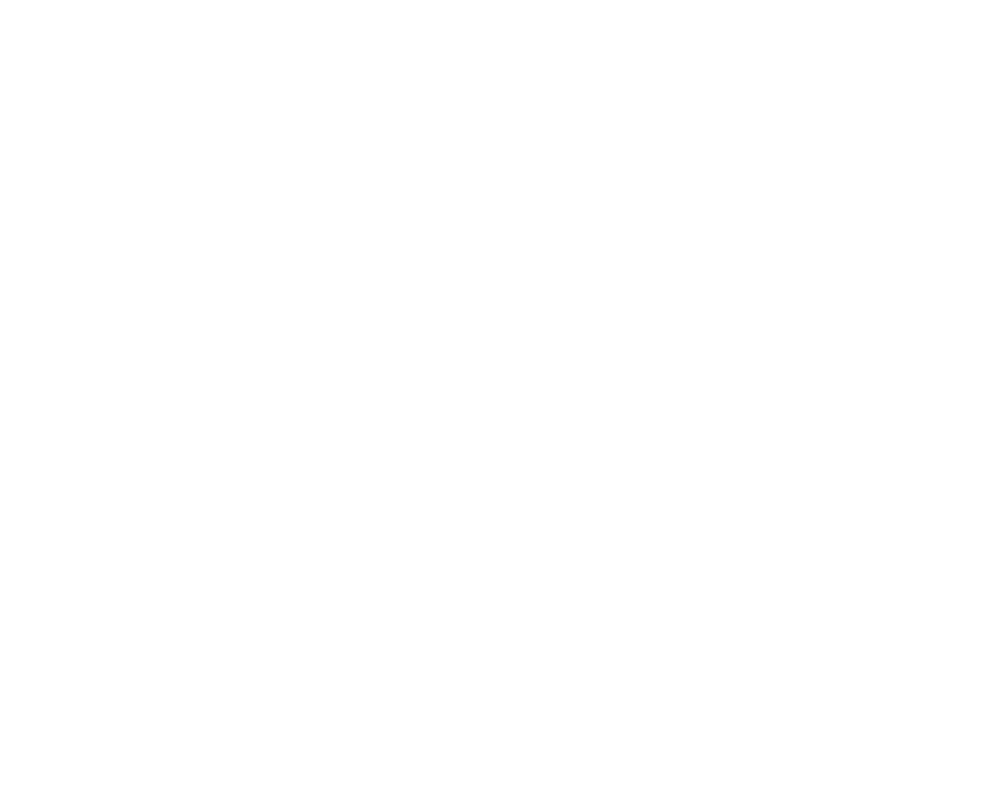

In [118]:
%matplotlib notebook
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,8))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')
sx, sy = [], []
while True:
    
    fig = plt.gcf()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)


    frame0 = cam0.get_frame(100)

    #gray = ax[0].imshow(frame0)
    #plt.colorbar(gray)

    mx = guess_centroid(frame0)
    bounds = bound_roi(frame0, mx, size = 400)
    imroi = select_roi(frame0, bounds)
    mxroi = guess_centroid(imroi)
    img = ax2.imshow(frame0)
    fig.colorbar(img)

    try:
        fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=False)
        sigma_x = fitc[2]
        sigma_y = fitr[2]
        p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]
        fit = fitGauss2d(imroi, p0 = p0)
        pars = make_params(fit);
        #if (pars[3] > 0 ) and (pars[4] > 0):
        if (pars[3] > 0 ) and (pars[3] < 200):
            sx.append(pars[3])
        #    sy.append(pars[4])
        ax3.plot(sx, label='$\sigma_x$')
        #ax3.plot(sy, label='$\sigma_y$')
        #ax3.set_ylim(15, 25)
        ax3.legend()
    
    except RuntimeError:
        pass
    
    
    plot_fit_result(imroi, pars, ax=ax1);
    fig.canvas.draw()
    fig.tight_layout()
    #fig.canvas.update()
    fig.canvas.flush_events()
    fig.subplots_adjust(left=0.2, bottom=None, right=0.8, top=None, wspace=0.1, hspace=None)
    plt.clf()     # Clean figure to update legend, barplot...    

<IPython.core.display.Javascript object>


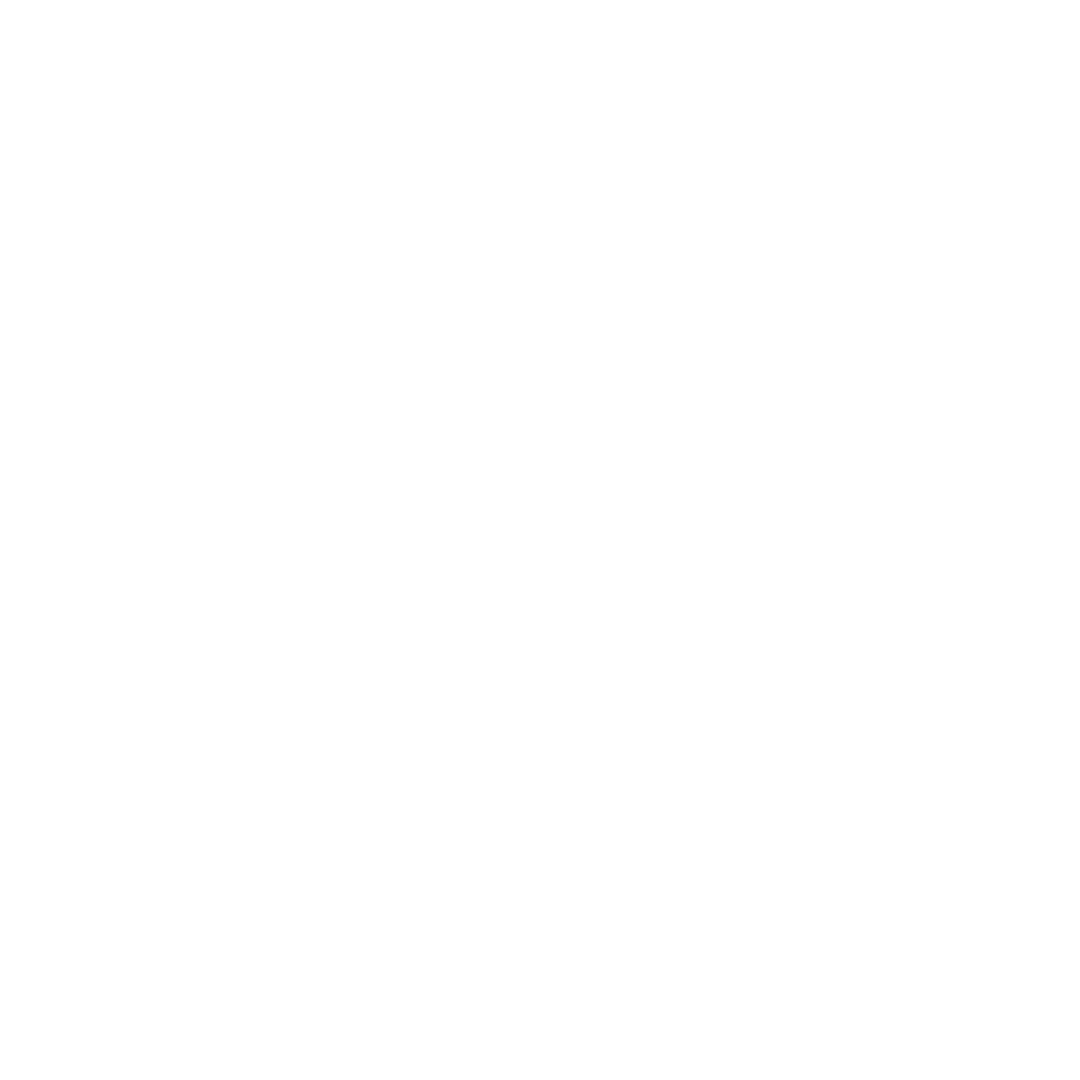

<IPython.core.display.Javascript object>


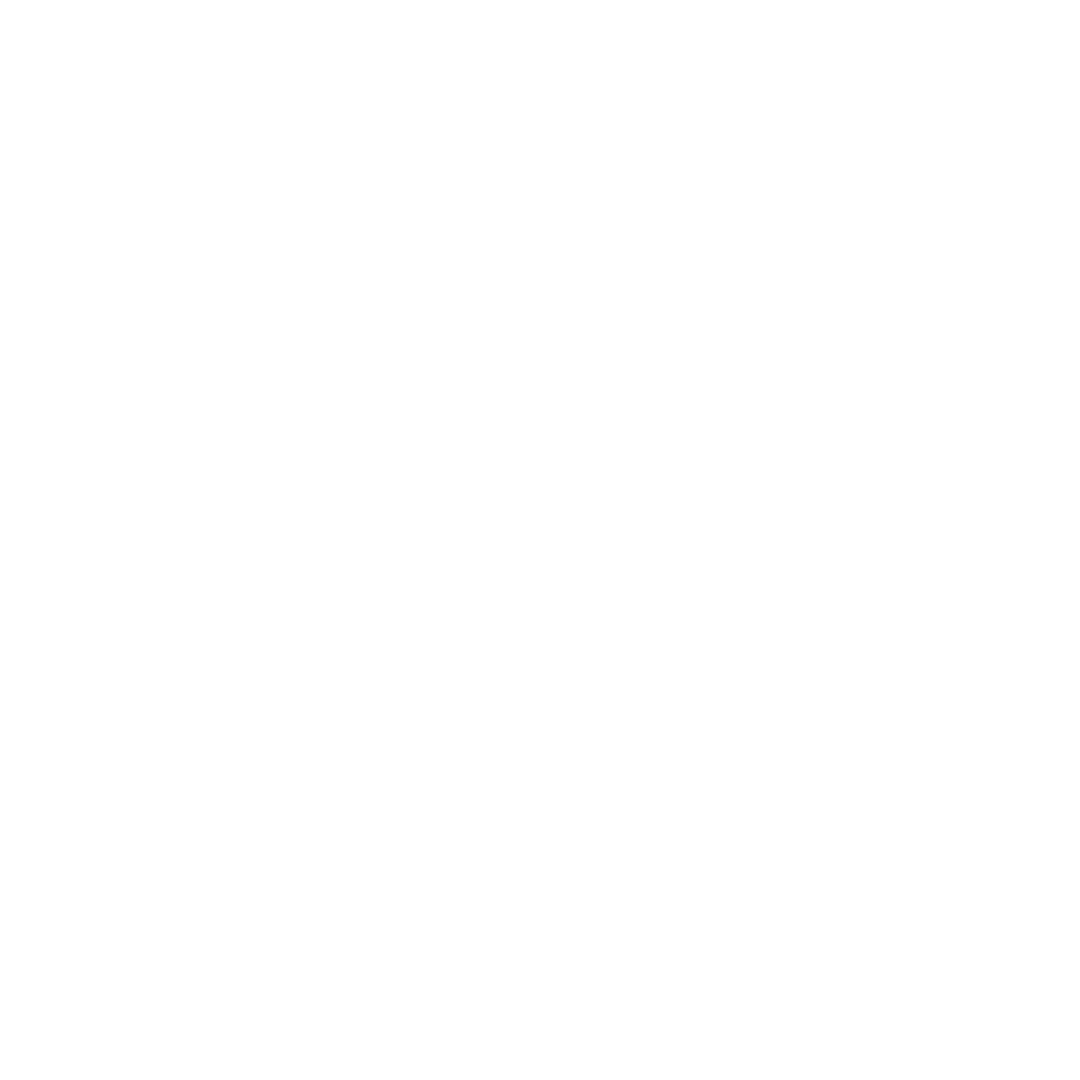

In [103]:
%matplotlib notebook
frame0 = cam0.get_frame(100)
fig, ax = plt.subplots (1, 2, figsize=(15,15))
gray = ax[0].imshow(frame0)
#bestfit2 = guessNfitGaussian2d(frame0, DEBUG=True)
#plot_fit_result(frame0, bestfit2)
mx = guess_centroid(frame0)
bounds = bound_roi(frame0, mx, size = 100)
imroi = select_roi(frame0, bounds)
mxroi = guess_centroid(imroi)
ax[1].imshow(imroi)

fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=False)
sigma_x = fitc[2]
sigma_y = fitr[2]
p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]

fit = fitGauss2d(imroi, p0 = p0)
pars = make_params(fit);
plot_fit_result(imroi, pars)
plt.legend()
plt.colorbar(gray)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/lens2_focus.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


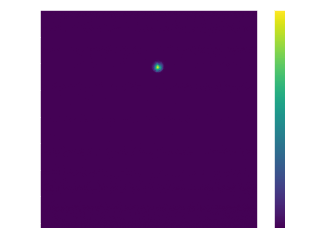

In [128]:
%matplotlib inline
frame2 = cam0.get_frame(100)

gray = plt.imshow(frame2)

plt.colorbar(gray)
io.imsave('./aligning_4f_052020/lens2_focus.tiff', frame2)

##### So se set position of lens 2, z2 = 4.13  and  zcam = 9.45mm, and $\Delta$z = z2 + zcam = 13.58 mm

In [275]:
# Relative position for reference (coordinated movement): the actual distance is 35-ish cm + dist_f2
dist_f2 =  9.45 + 4.13
dist_f2

13.579999999999998

# Set lens 1 at d = 40 cm from galvo, now cam and lens 2 move together 

<IPython.core.display.Javascript object>


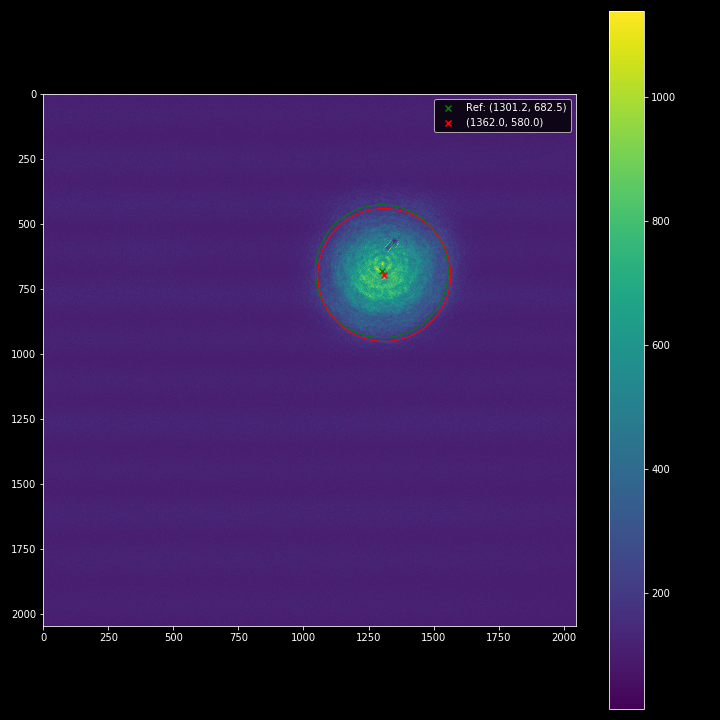

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


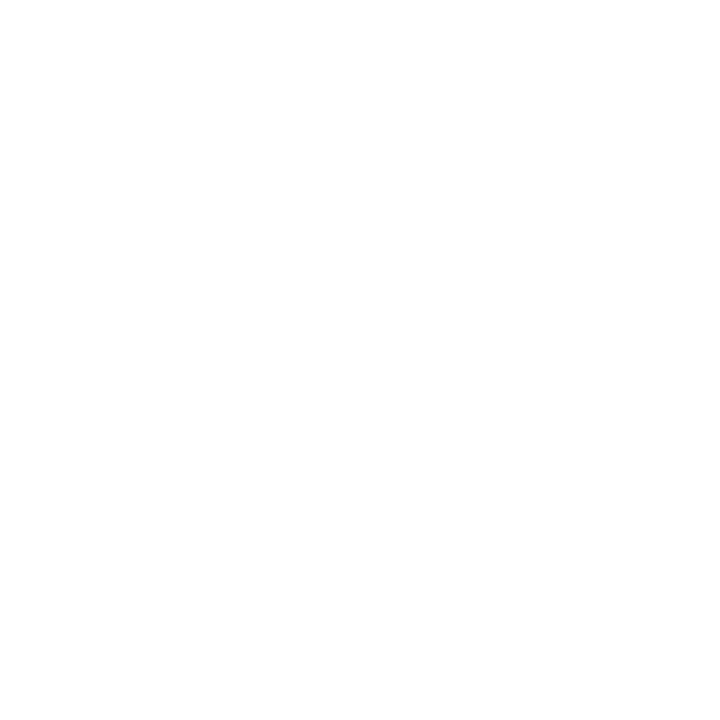

In [210]:
%matplotlib notebook
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,10))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')
sx, sy = [], []
while True:
    fig = plt.gcf()
    ax1 = fig.add_subplot(1, 1, 1)
    
    frame0 = cam0.get_frame(100)

    img = ax1.imshow(frame0)
    fig.colorbar(img)
    mx = guess_centroid(frame0)
 
    ax1.scatter(x=xref, y=yref, marker='x',
     color='g', label = 'Ref: (%.1f, %.1f)' %(xref, yref))

    circleRef = plt.Circle((xref, yref), radius=rRef, color='g', lw=1, fill=False,
     label = '$\omega = $ %.1f' %rRef)
    ax1.add_artist(circleRef)
    
    bounds = bound_roi(frame0, mx, size = 400)
    imroi = select_roi(frame0, bounds)
    mxroi = guess_centroid(imroi)

    try:
        fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=False)
        sigma_x = fitc[2]
        sigma_y = fitr[2]
        p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]
        fit = fitGauss2d(imroi, p0 = p0)
        pars = make_params(fit);
        p0 = zoom_out(pars, bounds)

    except RuntimeError:
        pass
    
    ax1.scatter(x=p0[1], y=p0[2], marker='x',
     color='r', label = '(%.1f, %.1f)' %(mx[1], mx[0])) 
    
    circle = plt.Circle((p0[1], p0[2]), radius=p0[3], color='r', lw=1, fill=False,
     label = '$\omega, = $ %.1f' %p0[3])
    
#    plot_fit_result(frame0, pars, ax=ax1);
    ax1.add_artist(circle)
    ax1.legend()
    fig.canvas.draw()
    fig.tight_layout()
    #fig.canvas.update()
    fig.canvas.flush_events()
    plt.clf()

C:\Users\IFIc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/lens1_center.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


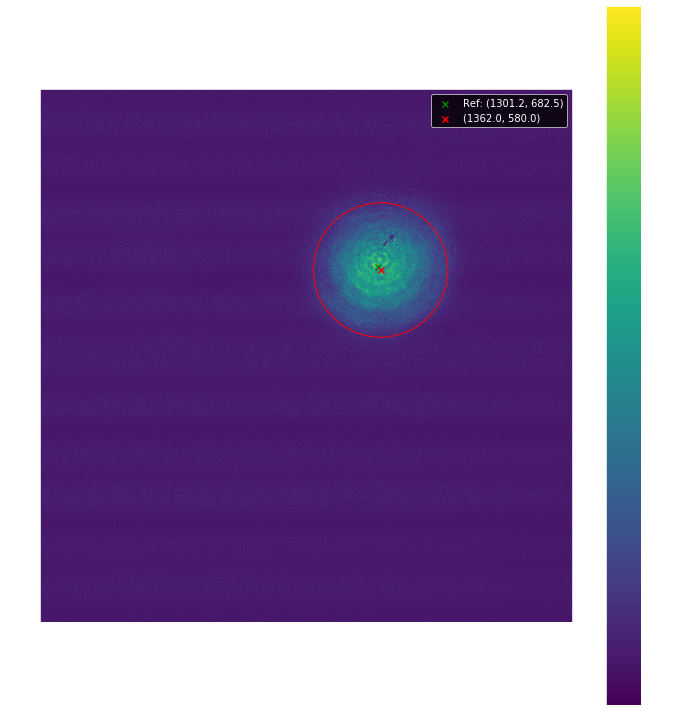

In [222]:
%matplotlib inline
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,10))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')

fig = plt.gcf()
ax1 = fig.add_subplot(1, 1, 1)

frame0 = cam0.get_frame(100)

img = ax1.imshow(frame0)
fig.colorbar(img)
mx = guess_centroid(frame0)
bounds = bound_roi(frame0, mx, size = 400)
imroi = select_roi(frame0, bounds)
mxroi = guess_centroid(imroi)

fitr, fitc = fitGausRowCol(imroi, mxroi,     flag_p=False)
sigma_x = fitc[2]
sigma_y = fitr[2]
p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]
fit = fitGauss2d(imroi, p0 = p0)
pars = make_params(fit);
p0 = zoom_out(pars, bounds)
ax1.scatter(x=xref, y=yref, marker='x',
 color='g', label = 'Ref: (%.1f, %.1f)' %(xref, yref))

ax1.scatter(x=p0[1], y=p0[2], marker='x',
     color='r', label = '(%.1f, %.1f)' %(mx[1], mx[0])) 

circle = plt.Circle((p0[1], p0[2]), radius=p0[3], color='r', lw=1, fill=False,
 label = '$\omega, = $ %.1f' %p0[3])

#    plot_fit_result(frame0, pars, ax=ax1);
ax1.add_artist(circle)
ax1.legend()

fig.canvas.draw()
fig.tight_layout()
#fig.canvas.update()
fig.canvas.flush_events()
io.imsave('./aligning_4f_052020/lens1_center.tiff', frame0)
plt.savefig('./aligning_4f_052020/lens1_center.png')

[2781.4084079099557,
 1301.1804046576372,
 682.4838725278931,
 255.2518064627757,
 0.049462923331967196]

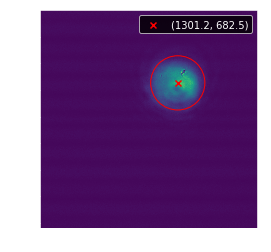

In [214]:
frame0 = plt.imread('./aligning_4f_052020/nolens_noIris_160cm.tiff')

%matplotlib inline
bestfit1 = guessNfitGaussian2d(frame0, flag_p=False)

plot_fit_result(frame0, bestfit1)
bestfit1

In [219]:
rRef

255.2518064627757

In [218]:
p0

[691.9843977308093,
 1310.3848886071,
 695.3759201120422,
 257.0105284755131,
 0.16518776356377474]

<IPython.core.display.Javascript object>


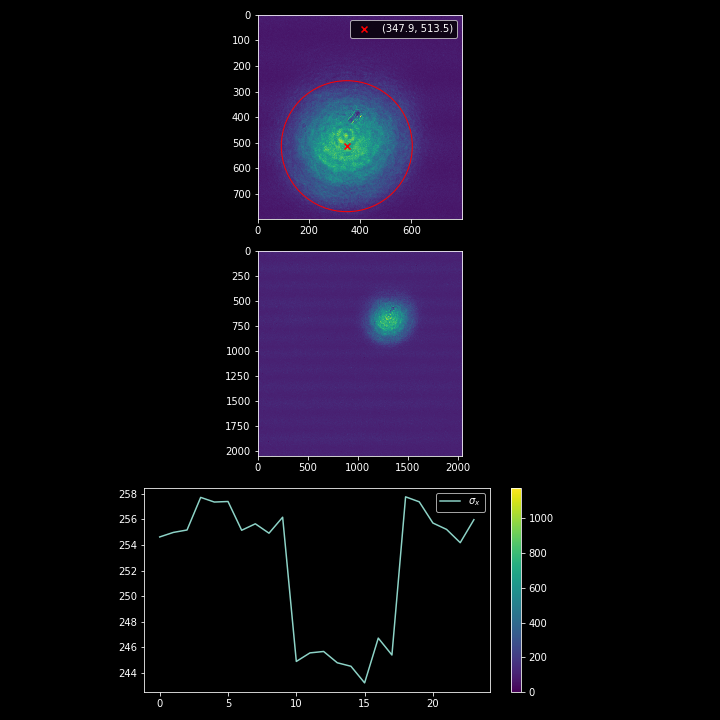

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


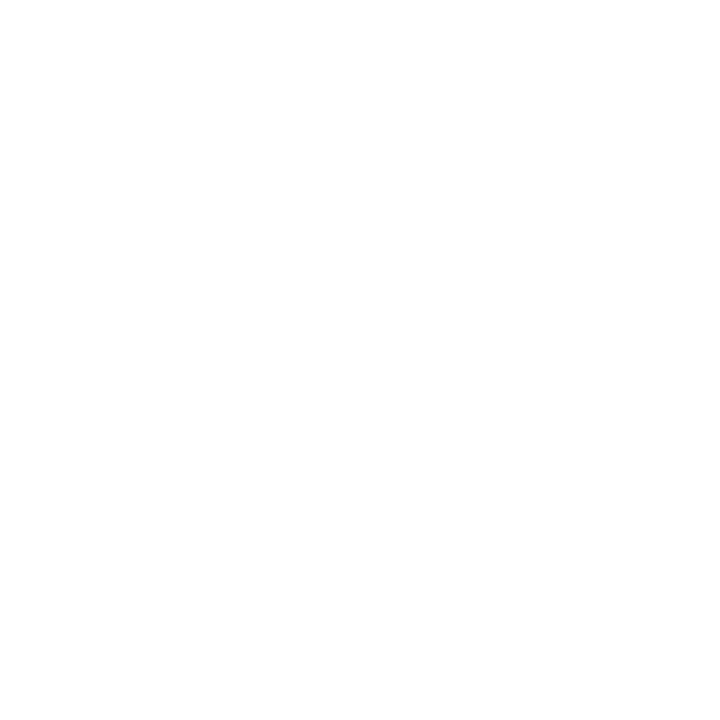

In [225]:
%matplotlib notebook
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,10))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')
sx, sy = [], []
while True:
    
    fig = plt.gcf()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)


    frame0 = cam0.get_frame(100)

    #gray = ax[0].imshow(frame0)
    #plt.colorbar(gray)

    mx = guess_centroid(frame0)
    bounds = bound_roi(frame0, mx, size = 400)
    imroi = select_roi(frame0, bounds)
    mxroi = guess_centroid(imroi)
    img = ax2.imshow(frame0)
    fig.colorbar(img)

    try:
        fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=False)
        sigma_x = fitc[2]
        sigma_y = fitr[2]
        p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]
        fit = fitGauss2d(imroi, p0 = p0)
        pars = make_params(fit);
        #if (pars[3] > 0 ) and (pars[4] > 0):
        if (pars[3] > 0 ) and (pars[3] < 300):
            sx.append(pars[3])
        #    sy.append(pars[4])
        ax3.plot(sx, label='$\sigma_x$')
        #ax3.plot(sy, label='$\sigma_y$')
        #ax3.set_ylim(15, 25)
        ax3.legend()
    
    except RuntimeError:
        pass 
    
    plot_fit_result(imroi, pars, ax=ax1);
    fig.canvas.draw()
    fig.tight_layout()
    #fig.canvas.update()
    fig.canvas.flush_events()
    fig.subplots_adjust(left=0.2, bottom=None, right=0.8, top=None, wspace=0.1, hspace=None)
    plt.clf()     # Clean figure to update legend, barplot...    

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/lens1_pos.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


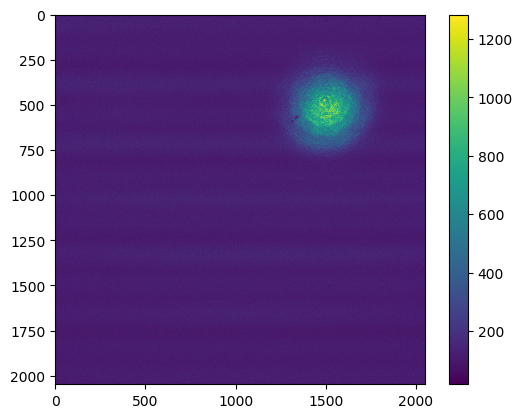

In [135]:
%matplotlib inline
plt.style.use('default')
frame2 = cam0.get_frame(100)

gray = plt.imshow(frame2)

plt.colorbar(gray)
io.imsave('./aligning_4f_052020/lens1_pos.tiff', frame2)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/nolens_noIris_160cm.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


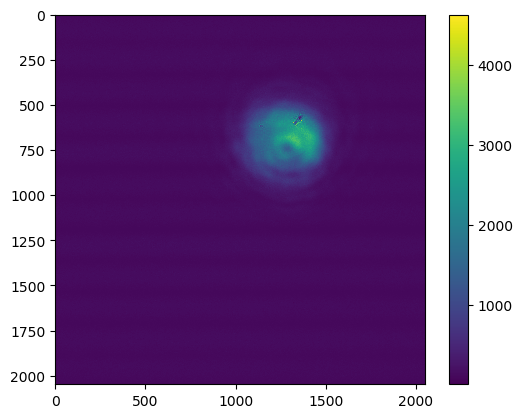

In [88]:
move_to_positionXY(serialport, [50,-40], center=center0)
sleep(1)
frame0 = cam0.get_frame(100)

gray = plt.imshow(frame0)
io.imsave('./aligning_4f_052020/nolens_noIris_160cm.tiff', frame0)
plt.colorbar(gray)

##### Lens 1 is set initially at max z pos (> 27 mm)

# Now move galvo in x and measure image center displacement 

In [268]:
p1 = [-1800, 0] # p1
p2 = [-3100, 0] # p2
p3 = [-4800, 0] # p3
p0 = [0,0]
p4 = [+1500, 0] # p4
p5 = [+3000, 0] # p5
p6 = [+900, 0] # p6
p7 = [-800, 0] # p7

r1 = [0, 600] # r1
r2 = [0, 1500] # r2
r3 = [0, -800] # r1
r4 = [0, -1500] # r1



move_to_positionXY(serialport, position=p0, center=center0)

In [269]:
hpoints = [p4, p6, p0, p7, p1, p2]
vpoints = [r2, r1, p0, r3, r4]

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./galvoScanX1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1847.2512085904489, 715.7245505770063]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./galvoScanX900.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1635.8190900017576, 698.9230001860448]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./galvoScanX0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1311.5795953511617, 693.2466408509981]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./galvoScanX-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1037.9777784104106, 687.1430163149707]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./galvoScanX-1800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[662.3053455618797, 685.4168327172242]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./galvoScanX-3100.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[202.10496179854408, 683.1424297145779]


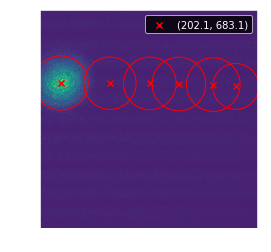

In [270]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz0/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

[1304.3032822543523, -102.52738336223142]
[1310.0308257888883, 373.198443079823]
[1310.4666469894244, 691.6356841274111]
[1308.9314225589446, 1116.0337921035202]
[1307.8519900258902, 1490.2173906363332]


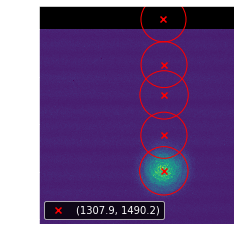

In [273]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz0/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Displace both lenses and cam 9.45 mm and see how if there is less image movement

Originally:

zl1 = 27 mm,

zl2 = 4.13 mm

zcam = 9.45 mm

Now:
zl1 = 17.55 mm

zl2 = 13.57 mm

zcam = 0

In [278]:
27-9.45

17.55

[1847.0047109975662, 702.1759403890414]
[1637.8873169618978, 702.3889086088086]
[1327.953748380335, 699.2027875668307]
[1071.956248476188, 694.2943296927057]
[710.4503288150323, 692.6215502561338]
[275.2803530298897, 689.5453711656301]


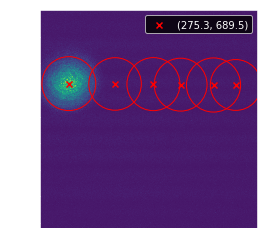

In [281]:
%matplotlib inline
fitsh9 = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh9.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz9/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

[1330.7049338305114, -51.41735452761993]
[1332.1682024857269, 395.0004775283012]
[1327.9942100804278, 699.2043291407955]
[1332.0415025589466, 1102.5711308849104]
[1324.2919207847442, 1455.6558317892582]


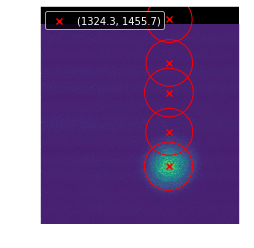

In [282]:
%matplotlib inline
fitsv9 = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv9.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz9/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

### Quantify results, measure displacement from p0

In [289]:
fitsv = np.matrix([[1304.3032822543523, -102.52738336223142],
[1310.0308257888883, 373.198443079823],
[1310.4666469894244, 691.6356841274111],
[1308.9314225589446, 1116.0337921035202],
[1307.8519900258902, 1490.2173906363332]])

fitsv[:, 1] - fitsv[2, 1]

In [295]:
fitsv[:, 1] - fitsv[2, 1]

matrix([[-794.16306749],
        [-318.43724105],
        [   0.        ],
        [ 424.39810798],
        [ 798.58170651]])

In [297]:
fitsh = np.matrix([[1847.2512085904489, 715.7245505770063],
[1635.8190900017576, 698.9230001860448],
[1311.5795953511617, 693.2466408509981],
[1037.9777784104106, 687.1430163149707],
[662.3053455618797, 685.4168327172242],
[202.10496179854408, 683.1424297145779] ])

fitsh[:, 0] - fitsh[2, 0]

## Displace both lenses and cam 50 mm (2" screw places)

Now:

zl1 = 17.55 mm,

zl2 = 13.57 mm

zcam = 0

[1715.550772782773, 736.0715497400348]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz50/galvoScanX900.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1561.0499383657234, 736.070888810377]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz50/galvoScanX0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1350.5755884105906, 730.6266492874182]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz50/galvoScanX-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1146.9600155141245, 729.6237620521]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz50/galvoScanX-1800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[885.9610489675533, 725.2630647685794]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz50/galvoScanX-3100.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[555.2965411800162, 722.9743612483211]


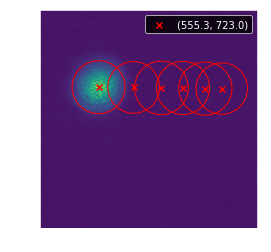

In [308]:
%matplotlib inline
fitsh50 = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh50.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz50/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz50/galvoScanY1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1337.9578131286053, 189.17331545375615]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz50/galvoScanY600.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1332.549389095702, 517.9780362066506]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz50/galvoScanY0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1345.1105214869367, 732.5910004201655]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz50/galvoScanY-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1331.3652290090458, 1019.5607062329489]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz50/galvoScanY-1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1335.584622328229, 1273.9233349292786]


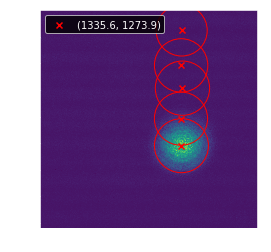

In [309]:
%matplotlib inline
fitsv50 = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv50.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz50/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Displace both lenses and cam 50 mm (2") -9.45 mm (before getting any closer)

Originally:

zl1 = 17.55 mm

zl2 = 13.57 mm

zcam = 0

Now:

zl1 = 27 mm,

zl2 = 4.13 mm

zcam = 9.45 mm

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanX1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1734.3467643041895, 729.6291733737055]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanX900.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1575.9190684309624, 728.1231824983995]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanX0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1333.5093360955702, 727.177115792357]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanX-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1125.5745050026608, 723.2343546529837]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanX-1800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[853.3852030385251, 718.9414368318108]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanX-3100.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[501.89377777536697, 717.543828762568]


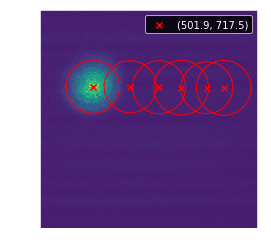

In [312]:
%matplotlib inline
fitsh59 = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh59.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz59/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanY1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1326.8119772968646, 152.0895554959783]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanY600.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1322.109223549167, 499.1502644158875]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanY0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1333.0438503118726, 728.0330915552751]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanY-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1319.9288434930586, 1031.8954044457087]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz59/galvoScanY-1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1324.6726710271892, 1302.0465052066284]


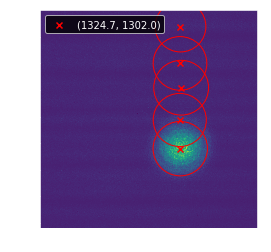

In [313]:
%matplotlib inline
fitsv59 = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv59.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz59/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Displace both lenses and cam 2.5 mm (1" screw place) more

[1406.1972994189357, 749.6570681854575]
[1282.3609495140818, 749.7979235325371]
[1093.3989954695603, 748.480554657383]
[935.0395900346367, 746.1077156086463]
[730.2807880518513, 742.8839502080034]
[443.3264528135112, 745.4549172888493]


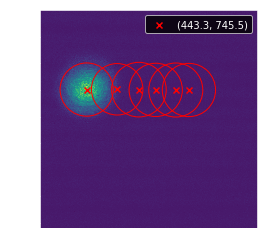

In [320]:
%matplotlib inline
fitsh25 = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh25.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz25/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz25/galvoScanY1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1102.1739719403658, 315.99092884073735]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz25/galvoScanY600.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1097.7136522001124, 575.4673675673355]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz25/galvoScanY0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1092.7617260829218, 748.6321471467077]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz25/galvoScanY-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1096.554976420216, 974.1012761616201]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatz25/galvoScanY-1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1095.0445721447982, 1174.8025153992578]


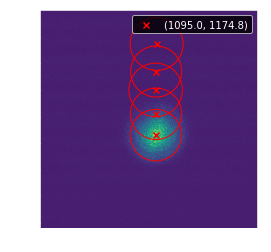

In [321]:
%matplotlib inline
fitsv25 = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv25.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz25/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Displace both lenses and cam 2.5 mm (1") - 9.45 mm

Originally:

zl1 = 17.55 mm

zl2 = 13.57 mm

zcam = 0

Now:

zl1 = 27 mm,

zl2 = 4.13 mm

zcam = 9.45 mm


[1477.0117007617978, 744.1249294413576]
[1343.7569806821002, 743.2828103512003]
[1141.7057540379765, 741.0612044024506]
[968.6903412634402, 738.6284577935368]
[738.2237560087218, 736.4607018455481]
[738.0263437560154, 736.2655386404654]


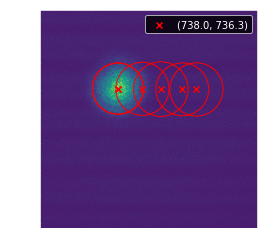

In [335]:
%matplotlib inline
fitsh29 = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh29.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz29/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

[1141.4936178643334, 270.8355169037331]
[1134.9516036650032, 554.3701336438553]
[1141.3438384003175, 741.6142372843482]
[1133.8500990842995, 989.5096426623682]
[1135.0345662829413, 1207.6276746308213]


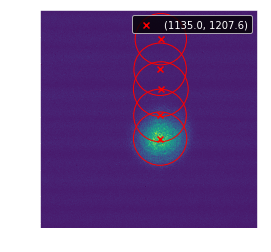

In [333]:
%matplotlib inline
fitsv29 = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv29.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatz29/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Displace both lenses and cam 2.5 mm (1" screw place) more

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanX1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1556.7605974600842, 763.2313637913082]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanX900.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1460.7309712680108, 762.9110868542541]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanX0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1312.9899115261173, 762.4317401010557]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanX-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1173.6349330148244, 761.7139909427042]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanX-1800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1008.451116997222, 758.6877916328629]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanX-3100.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[800.7254381619313, 754.6716130475962]


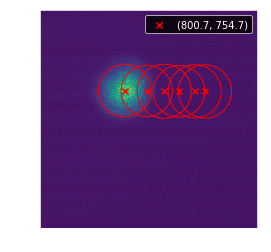

In [337]:
%matplotlib inline
fitshb = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitshb.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzb/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanY1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1311.3169850764568, 430.88814657751743]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanY600.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1310.2536299767435, 632.5575780289726]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanY0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1312.4476692350256, 761.1370315301886]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanY-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1311.0499658077229, 935.0517932305652]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzb/galvoScanY-1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1311.6248592793645, 1087.5371729128842]


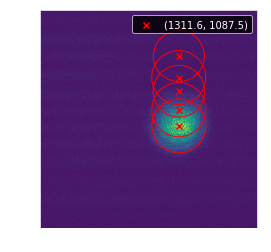

In [338]:
%matplotlib inline
fitsvb = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsvb.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzb/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Position c: z = 37 cm (33.5 to screw hole)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanX1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1608.9098352362498, 780.7046820119632]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanX900.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1526.520833667548, 781.3736971406853]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanX0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1405.1980942621647, 781.562973869323]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanX-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1300.9213560045218, 782.0016448581193]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanX-1800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1171.0730480738869, 781.6025281969582]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanX-3100.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[996.5797051716218, 778.8607052845047]


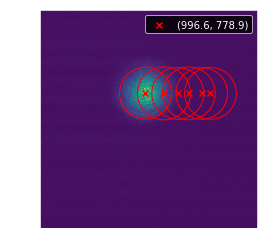

In [393]:
%matplotlib inline
fitshc = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitshc.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzc/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanY1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1412.6216310385714, 542.1241414794208]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanY600.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1407.2826548912324, 687.9280000145403]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanY0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1404.8432827465317, 781.6421278122449]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanY-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1404.105202521101, 904.1828672461767]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzc/galvoScanY-1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1404.4432675932844, 1014.4567847951375]


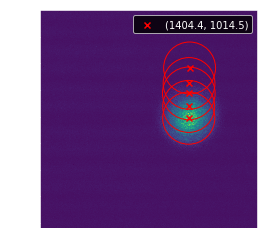

In [394]:
%matplotlib inline
fitsvc = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsvc.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzc/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Position d: z = 34.5 cm (31 to screw hole)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanX1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1542.9895882899402, 796.266721651778]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanX900.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1489.0000936068209, 797.9576291526114]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanX0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1411.4322927665794, 798.1367077079049]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanX-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1344.7100126979722, 798.8442880814309]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanX-1800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1261.9605620648686, 798.6946010417574]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanX-3100.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1152.7696743488705, 798.1132049897589]


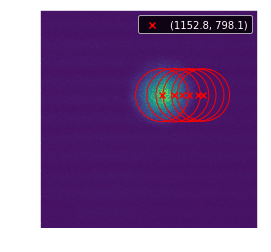

In [397]:
%matplotlib inline
fitshd = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitshd.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzd/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanY1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1418.576307012811, 672.8271894488853]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanY600.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1413.2060552862285, 750.850676736218]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanY0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1411.1495249423497, 799.1657883972556]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanY-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1410.6155485447982, 858.8877431510732]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzd/galvoScanY-1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1411.0403904922628, 914.4991174508546]


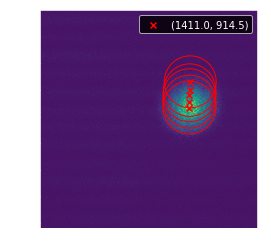

In [398]:
%matplotlib inline
fitsvd = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsvd.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzd/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Position e: z = 32.0 cm (28.5 to screw hole)

[1253.4744755484617, 810.0618962927362]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatze/galvoScanX900.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1252.3673223872952, 811.0755795920286]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatze/galvoScanX0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1191.667028820039, 811.9103383745394]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatze/galvoScanX-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1160.353455362576, 813.6693796521673]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatze/galvoScanX-1800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1127.805510371281, 812.5954232409515]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatze/galvoScanX-3100.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1078.3823893259928, 812.9421684621483]


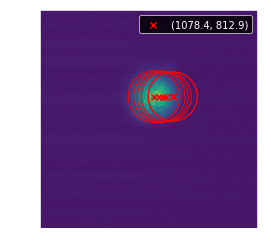

In [407]:
%matplotlib inline
fitshe = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitshe.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatze/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatze/galvoScanY1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1200.985734642749, 778.4481047175991]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatze/galvoScanY600.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1189.0862670726488, 808.1195597824479]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatze/galvoScanY0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1187.8050452838374, 813.687590185488]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatze/galvoScanY-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1185.7503694671398, 815.793095166084]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatze/galvoScanY-1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1186.318266709518, 822.0997154800807]


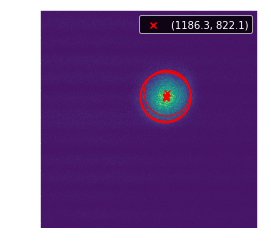

In [408]:
%matplotlib inline
fitsve = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsve.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatze/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Position g: z = 29.5 cm (26.0 to screw hole)

[1258.8644248772796, 814.4134176292072]
[1261.6649985011047, 811.1924460835578]
[1266.6970379589627, 813.6148248003072]
[1273.2236853773047, 816.6078885366213]
[1300.5734378478264, 818.5433487707596]
[1314.172975033782, 823.418776049207]


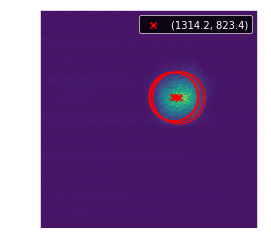

In [421]:
%matplotlib inline
fitshg = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitshg.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzg/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

[1291.0533736247332, 877.6479972020306]
[1268.3593014313556, 869.3300057184255]
[1269.5288151434459, 825.8451866634075]
[1266.5940677522792, 764.2898921889162]
[1268.0964788607203, 714.034492324616]


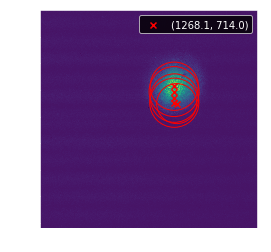

In [422]:
%matplotlib inline
fitsvg = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsvg.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzg/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Position g9: z = 30.5 cm (26.0 to screw hole) (move to 9 position of displacer)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanX1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1270.3796140063498, 816.1255046971994]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanX900.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1262.4472868693356, 814.718209065313]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanX0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1255.7592924195988, 820.2564088515975]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanX-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1253.8297920006864, 819.4230603967803]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanX-1800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1249.2260541374467, 822.3491009341251]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanX-3100.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1245.6000768363092, 818.1586431359428]


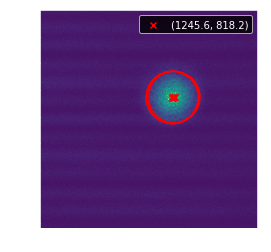

In [428]:
%matplotlib inline
fitshg9 = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitshg9.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzg9/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanY1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1275.3650305367473, 849.9366352526304]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanY600.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1257.5675177747362, 847.6610912916535]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanY0.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1255.7128851341072, 818.5898490028213]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanY-800.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1253.7232467570327, 777.000820573566]


C:\Users\IFIc\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./aligning_4f_052020/scanXYatzg9/galvoScanY-1500.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


[1255.7096355749347, 745.1977186665113]


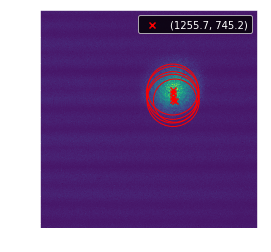

In [429]:
%matplotlib inline
fitsvg9 = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsvg9.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzg9/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Quantify results 

In [296]:
np.matrix(fitsv9)[:, 2] - np.matrix(fitsv9)[2, 2]

matrix([[-750.62168367],
        [-304.20385161],
        [   0.        ],
        [ 403.36680174],
        [ 756.45150265]])

In [302]:
np.matrix(fitsh9)[:, 1] - np.matrix(fitsh9)[2, 1]

matrix([[  519.05096262],
        [  309.93356858],
        [    0.        ],
        [ -255.9974999 ],
        [ -617.50341957],
        [-1052.67339535]])

In [314]:
np.matrix(fitsv50)[:, 2] - np.matrix(fitsv50)[2, 2]

matrix([[-543.41768497],
        [-214.61296421],
        [   0.        ],
        [ 286.96970581],
        [ 541.33233451]])

In [315]:
np.matrix(fitsh50)[:, 1] - np.matrix(fitsh50)[2, 1]

matrix([[ 364.97518437],
        [ 210.47434996],
        [   0.        ],
        [-203.6155729 ],
        [-464.61453944],
        [-795.27904723]])

In [316]:
np.matrix(fitsv59)[:, 2] - np.matrix(fitsv59)[2, 2]

matrix([[-575.94353606],
        [-228.88282714],
        [   0.        ],
        [ 303.86231289],
        [ 574.01341365]])

In [317]:
np.matrix(fitsh59)[:, 1] - np.matrix(fitsh59)[2, 1]

matrix([[ 400.83742821],
        [ 242.40973234],
        [   0.        ],
        [-207.93483109],
        [-480.12413306],
        [-831.61555832]])

In [322]:
np.matrix(fitsv25)[:, 2] - np.matrix(fitsv25)[2, 2]

matrix([[-432.64121831],
        [-173.16477958],
        [   0.        ],
        [ 225.46912901],
        [ 426.17036825]])

In [324]:
np.matrix(fitsh25)[:, 1] - np.matrix(fitsh25)[2, 1]

matrix([[ 312.79830395],
        [ 188.96195404],
        [   0.        ],
        [-158.35940543],
        [-363.11820742],
        [-650.07254266]])

In [327]:
np.matrix(fitsv29)[:, 2] - np.matrix(fitsv29)[2, 2]

matrix([[-470.3614665 ],
        [-187.28162085],
        [   0.        ],
        [ 248.71965381],
        [ 467.95618111]])

In [336]:
np.matrix(fitsh29)[:, 1] - np.matrix(fitsh29)[2, 1]

matrix([[ 335.30594672],
        [ 202.05122664],
        [   0.        ],
        [-173.01541277],
        [-403.48199803],
        [-403.67941028]])

In [340]:
np.matrix(fitsvb)[:, 2] - np.matrix(fitsvb)[2, 2]

matrix([[-330.24888495],
        [-128.5794535 ],
        [   0.        ],
        [ 173.9147617 ],
        [ 326.40014138]])

In [339]:
np.matrix(fitshb)[:, 1] - np.matrix(fitshb)[2, 1]

matrix([[ 243.77068593],
        [ 147.74105974],
        [   0.        ],
        [-139.35497851],
        [-304.53879453],
        [-512.26447336]])

In [395]:
np.matrix(fitsvc)[:, 2] - np.matrix(fitsvc)[2, 2]

matrix([[-239.51798633],
        [ -93.7141278 ],
        [   0.        ],
        [ 122.54073943],
        [ 232.81465698]])

In [396]:
np.matrix(fitshc)[:, 1] - np.matrix(fitshc)[2, 1]

matrix([[ 203.71174097],
        [ 121.32273941],
        [   0.        ],
        [-104.27673826],
        [-234.12504619],
        [-408.61838909]])

In [399]:
np.matrix(fitsvd)[:, 2] - np.matrix(fitsvd)[2, 2]

matrix([[-126.33859895],
        [ -48.31511166],
        [   0.        ],
        [  59.72195475],
        [ 115.33332905]])

In [400]:
np.matrix(fitshd)[:, 1] - np.matrix(fitshd)[2, 1]

matrix([[ 131.55729552],
        [  77.56780084],
        [   0.        ],
        [ -66.72228007],
        [-149.4717307 ],
        [-258.66261842]])

In [409]:
np.matrix(fitsve)[:, 2] - np.matrix(fitsve)[2, 2]

matrix([[-35.23948547],
        [ -5.5680304 ],
        [  0.        ],
        [  2.10550498],
        [  8.41212529]])

In [410]:
np.matrix(fitshe)[:, 1] - np.matrix(fitshe)[2, 1]

matrix([[  61.80744673],
        [  60.70029357],
        [   0.        ],
        [ -31.31357346],
        [ -63.86151845],
        [-113.28463949]])

In [423]:
np.matrix(fitsvg)[:, 2] - np.matrix(fitsvg)[2, 2]

matrix([[  51.80281054],
        [  43.48481906],
        [   0.        ],
        [ -61.55529447],
        [-111.81069434]])

In [424]:
np.matrix(fitshg)[:, 1] - np.matrix(fitshg)[2, 1]

matrix([[-7.83261308],
        [-5.03203946],
        [ 0.        ],
        [ 6.52664742],
        [33.87639989],
        [47.47593707]])

In [430]:
np.matrix(fitsvg9)[:, 2] - np.matrix(fitsvg9)[2, 2]

matrix([[ 31.34678625],
        [ 29.07124229],
        [  0.        ],
        [-41.58902843],
        [-73.39213034]])

In [431]:
np.matrix(fitshg9)[:, 1] - np.matrix(fitshg9)[2, 1]

matrix([[ 14.62032159],
        [  6.68799445],
        [  0.        ],
        [ -1.92950042],
        [ -6.53323828],
        [-10.15921558]])

##### The closer we get the less displacement between galvo positions, but the image does not stay as big

In [353]:
np.matrix(fitsv9)[:, 3]

matrix([[235.81731872],
        [239.24324698],
        [249.94361156],
        [241.13859201],
        [248.03011748]])

In [342]:
np.matrix(fitsh9)[:, 3]

matrix([[239.35130785],
        [254.94166315],
        [248.99551458],
        [249.70998435],
        [247.35249692],
        [253.85703365]])

In [343]:
np.matrix(fitsv50)[:, 3]

matrix([[240.45897148],
        [251.36668103],
        [255.7346784 ],
        [250.42902067],
        [254.46491568]])

In [344]:
np.matrix(fitsh50)[:, 3]

matrix([[242.30457551],
        [250.48075247],
        [250.49836291],
        [252.4397603 ],
        [243.60470185],
        [249.51350232]])

In [345]:
np.matrix(fitsv59)[:, 3]

matrix([[238.98473237],
        [252.72386108],
        [258.01316104],
        [250.06640781],
        [256.19389627]])

In [346]:
np.matrix(fitsh59)[:, 3]

matrix([[257.51498301],
        [243.95264379],
        [257.50015699],
        [249.37028607],
        [245.64559516],
        [251.17593599]])

In [347]:
np.matrix(fitsv25)[:, 3]

matrix([[249.37414308],
        [240.77639216],
        [252.08422915],
        [242.10165008],
        [242.58509806]])

In [348]:
np.matrix(fitsh25)[:, 3]

matrix([[250.78766398],
        [254.47164078],
        [250.91725387],
        [257.23458021],
        [242.31942323],
        [250.66043488]])

In [349]:
np.matrix(fitsv29)[:, 3]

matrix([[241.58621978],
        [246.89663378],
        [258.01686795],
        [247.58698193],
        [251.11497243]])

In [350]:
np.matrix(fitsh29)[:, 3]

matrix([[250.58655101],
        [248.92886981],
        [256.99909179],
        [250.23202476],
        [242.4876662 ],
        [239.96866348]])

In [351]:
np.matrix(fitsvb)[:, 3]

matrix([[240.21167018],
        [254.29637382],
        [243.30604726],
        [254.92645524],
        [254.21296149]])

In [352]:
np.matrix(fitshb)[:, 3] 

matrix([[251.11002812],
        [250.3375638 ],
        [243.42635139],
        [254.87755821],
        [240.95535116],
        [247.87139876]])

In [401]:
np.matrix(fitsvc)[:, 3]

matrix([[244.44039506],
        [243.77722339],
        [248.07060335],
        [244.77385923],
        [245.58813212]])

In [402]:
np.matrix(fitshc)[:, 3] 

matrix([[244.04786548],
        [243.59166565],
        [248.27818204],
        [244.91034885],
        [249.476655  ],
        [244.38348163]])

In [412]:
np.matrix(fitsvd)[:, 3]

matrix([[244.81169521],
        [247.26830099],
        [249.27199347],
        [249.43608662],
        [249.51746449]])

In [411]:
np.matrix(fitshd)[:, 3] 

matrix([[246.50140151],
        [246.86168727],
        [249.48641606],
        [248.89408601],
        [251.77381611],
        [249.95326185]])

In [417]:
np.matrix(fitsve)[:, 3]

matrix([[216.61983448],
        [235.35540964],
        [239.37346597],
        [238.58457783],
        [237.89619676]])

In [418]:
np.matrix(fitshe)[:, 3] 

matrix([[231.62739538],
        [231.44422303],
        [236.35436736],
        [239.41820282],
        [242.55477258],
        [243.72047144]])

In [425]:
np.matrix(fitsvg)[:, 3]

matrix([[188.34918099],
        [231.62245337],
        [228.37064027],
        [235.48099719],
        [227.19761963]])

In [426]:
np.matrix(fitshg)[:, 3] 

matrix([[230.85239527],
        [231.4558693 ],
        [227.20874331],
        [228.49180306],
        [239.20613848],
        [247.36870642]])

In [432]:
np.matrix(fitsvg9)[:, 3]

matrix([[203.52127479],
        [245.91882687],
        [241.87383491],
        [248.8138383 ],
        [239.72861608]])

In [433]:
np.matrix(fitshg9)[:, 3] 

matrix([[242.04660453],
        [243.16889668],
        [246.18616541],
        [248.54264229],
        [245.59026977],
        [245.20007083]])

## Plot results

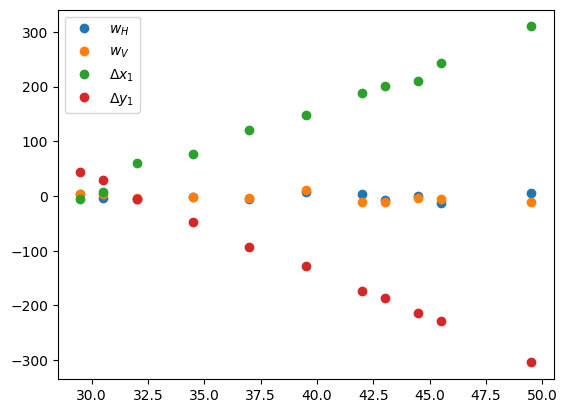

In [448]:
z = [49.5, 44.5, 45.5, 42, 43, 39.5, 37, 34.5, 32.0, 29.5, 30.5]
fitsV = [fitsv9, fitsv50, fitsv59, fitsv25, fitsv29, fitsvb, fitsvc, fitsvd, fitsve, fitsvg, fitsvg9]
fitsH = [fitsh9, fitsh50, fitsh59, fitsh25, fitsh29, fitshb, fitshc, fitshd, fitshe, fitshg, fitshg9]

sizesV = [np.matrix(f)[1, 3] - np.matrix(f)[2,3] for f in fitsV]
sizesH = [np.matrix(f)[1, 3] - np.matrix(f)[2,3] for f in fitsH]

dy1 = [np.matrix(f)[1, 2] - np.matrix(f)[2,2] for f in fitsV]
dx1 = [np.matrix(f)[1, 1] - np.matrix(f)[2,1] for f in fitsH]

dy2 = [np.matrix(f)[3, 2] - np.matrix(f)[2,2] for f in fitsV]
dx2 = [np.matrix(f)[3, 1] - np.matrix(f)[2,1] for f in fitsH]


plt.style.use('default')
plt.plot(z, sizesH, 'o', label='$w_H$')
plt.plot(z, sizesV, 'o', label='$w_V$')

plt.plot(z, dx1, 'o', label='$\Delta x_1$')
plt.plot(z, dy1, 'o', label='$\Delta y_1$')

#plt.plot(z, dx2, 'o', label='$\Delta x_2$')
#plt.plot(z, dy2, 'o', label='$\Delta y_2$')
plt.legend()

# Realign galvo center 

In [477]:
move_to_positionXY(serialport, position=[-50,-3250], center=center0)

## Position P: z = 30.5 cm (26.0 to screw hole) moved galvo and whole 4f 4 cm to the right

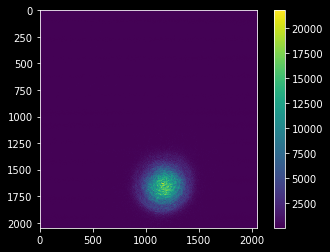

In [494]:
%matplotlib inline
plt.style.use('dark_background')

frame0 = cam0.get_frame(100)

gray = plt.imshow(frame0)
plt.colorbar(gray)
#bestfit2 = guessNfitGaussian2d(frame0)

[1134.735971065481, 1675.6603722109685]
[1142.298043777948, 1676.0960734913292]
[1157.7007788401866, 1675.6996644532846]
[1174.8484615314858, 1675.4596574038314]
[1196.7873729308412, 1674.9940860916988]
[1216.4806870287384, 1674.5378361246562]


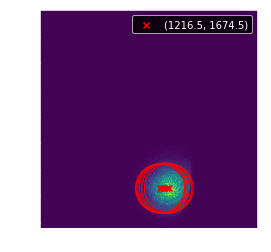

In [502]:
%matplotlib inline
fitshp0 = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitshp0.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzp0/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

[1162.3408631693228, 1782.357608422464]
[1157.850305786236, 1724.1579637930572]
[1156.6502953335785, 1673.3350991278564]
[1157.6793396219266, 1606.0050237487558]
[1161.3924007502665, 1553.6533627264466]


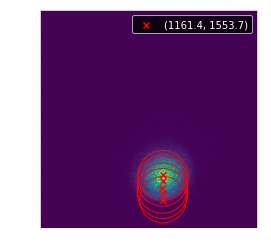

In [503]:
%matplotlib inline
fitsvp0 = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsvp0.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzp0/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

## Position P9: z = 29.5 cm (26.0 to screw hole) moved to 9.45 mm position

[1143.016948145263, 1665.7301559717755]
[1141.2370583933534, 1666.188380008671]
[1142.3542328139251, 1666.0474851595732]
[1146.2999727662825, 1665.5380618168044]
[1151.8103268709533, 1665.2961636919827]
[1146.7744936782015, 1664.6893615212366]


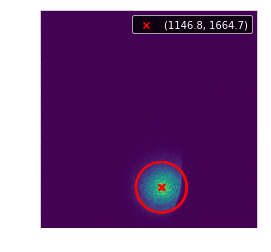

In [504]:
%matplotlib inline
fitshp9 = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitshp9.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzp9/galvoScanX' + str(hp[0])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)

[1145.9505245716741, 1732.8908632666655]
[1141.9549299028845, 1698.2002619136056]
[1141.2110530230966, 1663.531718472375]
[1142.2636777599878, 1617.685171336939]
[1145.3359485719961, 1583.8597903469067]


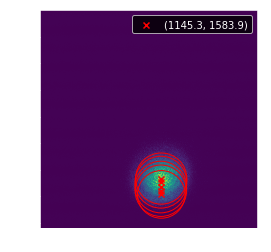

In [505]:
%matplotlib inline
fitsvp9 = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsvp9.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    io.imsave('./aligning_4f_052020/scanXYatzp9/galvoScanY' + str(vp[1])+'.tiff', frameh)
    print(bestfit1[1:3])
    sleep(5)